# Draft

In [43]:
import numpy as np
import pandas as pd

import scipy.stats as sps
import statsmodels.stats.diagnostic as smd

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import datetime as dt

from sklearn import linear_model

jtplot.style(figsize=(15, 9))

<AxesSubplot:xlabel='Datetime'>

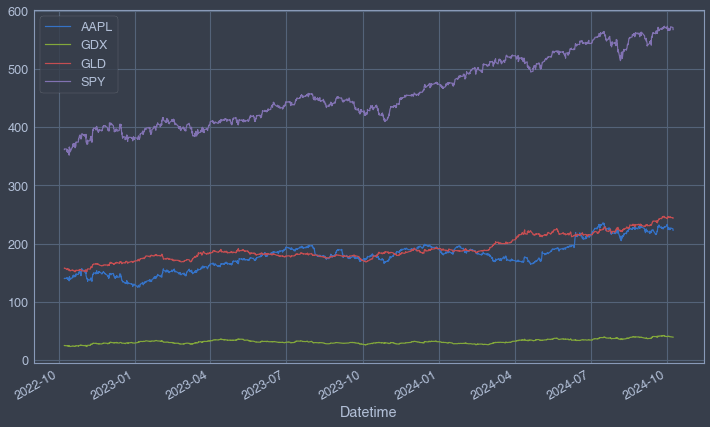

In [4]:
df = pd.read_csv('../../data/bt/gld_gdx_aapl_spy__1H.csv', parse_dates=True, header=[0, 1], index_col=0)
df.index = pd.to_datetime(df.index, utc=True)
df['Close'].plot()

In [5]:
symbol = 'GLD'
data = df['Close'][symbol].to_frame()
data.rename(columns={symbol: 'price'}, inplace=True)
data.head()

,price
Datetime,
2022-10-07 18:30:00+00:00,157.720001
2022-10-07 19:30:00+00:00,157.919998
2022-10-10 13:30:00+00:00,155.869995
2022-10-10 14:30:00+00:00,155.419998
2022-10-10 15:30:00+00:00,155.265106


In [17]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['price'].shift(lag) 
    cols.append(col)
data.dropna(inplace=True)

reg = np.linalg.lstsq(data[cols], data['price'], rcond=None)[0]
reg

array([ 1.00025153e+00,  1.19695769e-02, -6.57904650e-03, -3.84691200e-04,
       -5.12829351e-03])

In [20]:
data.head()

,price,lag_1,lag_2,lag_3,lag_4,lag_5,prediction,error,return,prediction return
Datetime,,,,,,,,,,
2022-10-12 14:30:00+00:00,155.529999,155.470001,155.199997,155.250000,156.259995,156.289993,155.483775,0.002137,0.000386,1.0
2022-10-12 15:30:00+00:00,155.449997,155.529999,155.470001,155.199997,155.250000,156.259995,155.547891,0.009583,-0.000515,-1.0
2022-10-12 16:30:00+00:00,155.570007,155.449997,155.529999,155.470001,155.199997,155.250000,155.472010,0.009604,0.000772,1.0
2022-10-12 17:30:00+00:00,156.070007,155.570007,155.449997,155.529999,155.470001,155.199997,155.590850,0.229591,0.003209,1.0
2022-10-12 18:30:00+00:00,155.880005,156.070007,155.570007,155.449997,155.529999,155.470001,156.091531,0.044743,-0.001218,1.0


In [25]:
data['prediction'] = np.dot(data[cols], reg)
data['error'] = data['price'] - data['prediction']

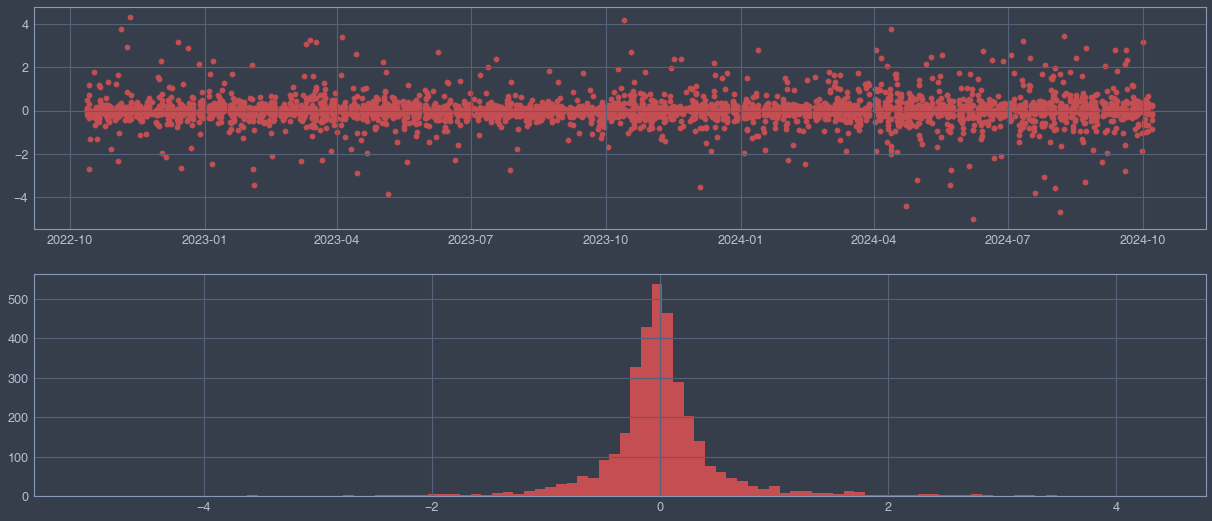

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(21, 9))
ax[0].scatter(data['error'].index, data['error'], c='r')
ax[1].hist(data['error'], bins=100, color='r');

In [27]:
data['error'].mean(), data['error'].std(), data['error'].median()

(0.0002542865549511544, 0.6257872917002905, -0.015859050584424494)

In [28]:
smd.het_breuschpagan(data['error'], data[['price', 'prediction']])

(248.37865509006414,
 5.860194136491974e-56,
 133.68985437518648,
 1.1728941927622109e-56)

In [29]:
sps.normaltest(data['error']).pvalue

2.9398362463677346e-148

<AxesSubplot:xlabel='Datetime'>

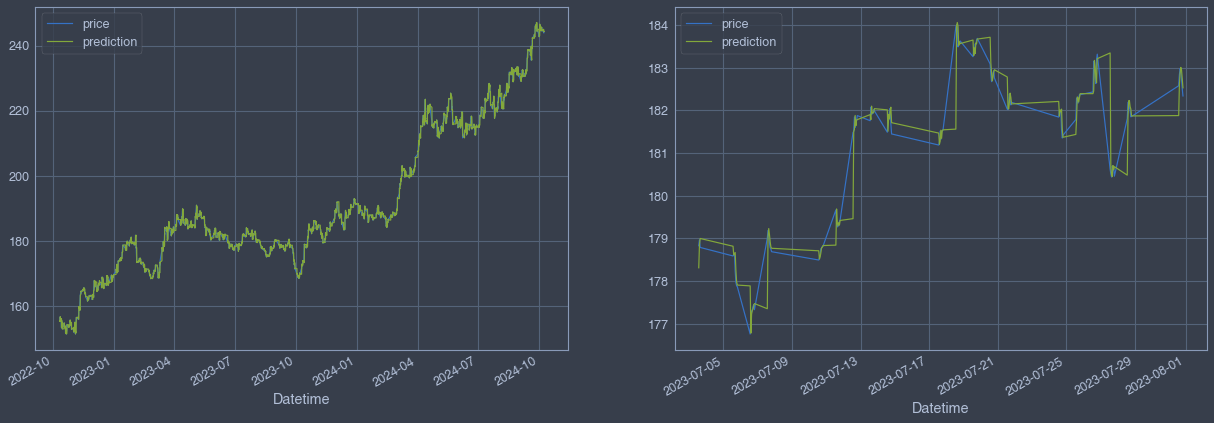

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(21, 7))
data[['price', 'prediction']].plot(ax=ax[0]);
data[['price', 'prediction']].loc['2023-07'].plot(ax=ax[1])

## Predicting Future Market Direction

In [30]:
data['return'] = np.log(data['price'] / data['price'].shift(1))
data.dropna(axis=0, inplace=True)

reg = np.linalg.lstsq(data[cols], np.sign(data['return']), rcond=None)[0]

data['prediction return'] = np.sign(np.dot(data[cols], reg))  
data['prediction return'].value_counts()

 1.0    3041
-1.0     427
Name: prediction return, dtype: int64

In [34]:
hits = np.sign(data['return']*data['prediction return']).value_counts()
hits

 1.0    1788
-1.0    1649
 0.0      31
dtype: int64

In [35]:
hits.values[0] / sum(hits)

0.5155709342560554

In [36]:
a = np.sign(data['return']*data['prediction return'])
data.loc[a[a==0].index]

,price,lag_1,lag_2,lag_3,lag_4,lag_5,prediction,error,return,prediction return
Datetime,,,,,,,,,,
2022-10-17 15:30:00+00:00,154.679993,154.679993,154.750000,152.940002,152.895004,152.960007,154.721751,-0.041758,0.0,1.0
2022-11-09 14:30:00+00:00,159.410004,159.410004,159.380005,159.199997,159.449997,159.460007,159.431330,-0.021327,0.0,1.0
2022-11-15 20:30:00+00:00,165.539993,165.539993,165.100006,165.139999,164.764999,164.725006,165.563203,-0.023210,0.0,1.0
2022-11-18 19:30:00+00:00,162.835007,162.835007,163.160004,163.070007,163.520004,163.485001,162.854772,-0.019765,0.0,1.0
2022-11-29 17:30:00+00:00,162.889999,162.889999,162.875000,163.529999,161.949997,162.044998,162.911329,-0.021330,0.0,1.0
2022-12-15 18:30:00+00:00,165.464996,165.464996,165.619995,165.330002,165.470001,168.089996,165.475634,-0.010637,0.0,-1.0
2023-01-17 17:30:00+00:00,177.389999,177.389999,177.929993,177.759995,178.729996,178.649796,177.409949,-0.019950,0.0,1.0
2023-03-02 17:30:00+00:00,170.550003,170.550003,170.755005,170.830002,170.809998,170.919907,170.570632,-0.020628,0.0,1.0
2023-03-06 20:30:00+00:00,171.669998,171.669998,171.725006,171.889999,172.010101,172.011200,171.689487,-0.019489,0.0,1.0


In [37]:
data['strategy'] = data['prediction return'] * data['return']
data[['return', 'strategy']].sum().apply(np.exp)

return      1.568508
strategy    1.497807
dtype: float64

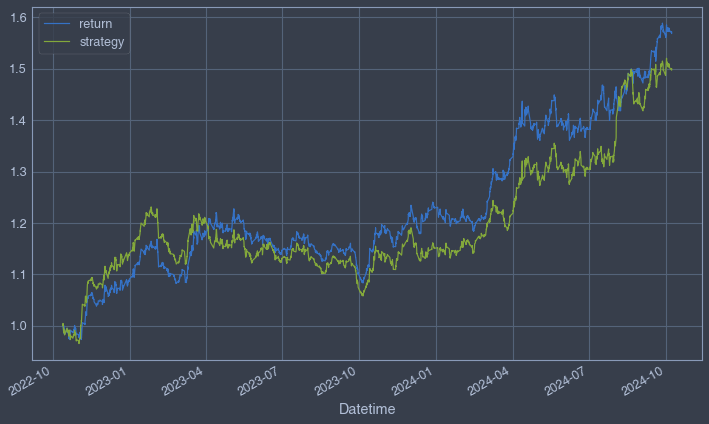

In [38]:
data[['return', 'strategy']].dropna().cumsum().apply(np.exp).plot();

In [45]:
lm = linear_model.LogisticRegression(max_iter=1000)  

lm.fit(data[cols], np.sign(data['return']))

data['prediction LogRes'] = lm.predict(data[cols])  
data['prediction LogRes'].value_counts()

 1.0    2596
-1.0     872
Name: prediction LogRes, dtype: int64

In [46]:
accuracy_score(np.sign(data['return']), data['prediction LogRes'])

0.5132641291810842

In [40]:
data['strategy LogRes'] = data['prediction LogRes'] * data['return']
data[['return', 'strategy LogRes']].sum().apply(np.exp)

return             1.568508
strategy LogRes    1.140695
dtype: float64

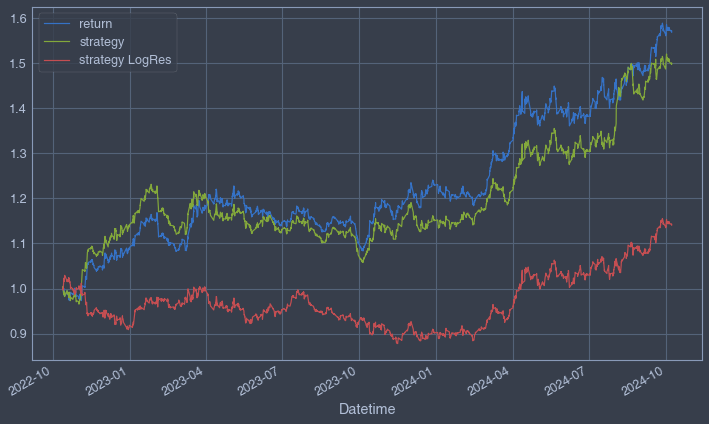

In [41]:
data[['return', 'strategy', 'strategy LogRes']].dropna().cumsum().apply(np.exp).plot();